Educational Data
================
This notebook gathers US census data from the American Community Survey (ACS)
related to car ownership, commuting time, distance, and mode of transportation.


In [2]:
from census import Census
import us
from us import states
import os
import pandas as pd
import geopandas as gpd
import requests

api_key = os.environ["CENSUS_API_KEY"]

In [22]:
# load the zipcodes we want to work with
zipcodes = gpd.read_file("./data/nyc-metro-zipcodes.geojson")
zipcodes

,zipcode,GEOID20,GEOIDFQ20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,06482,06482,860Z200US06482,B5,G6350,S,52432748,1863999,+41.4090005,-073.2426304,"POLYGON ((-73.31391 41.43918, -73.31379 41.439..."
1,06470,06470,860Z200US06470,B5,G6350,S,96379629,1789732,+41.3950832,-073.3176626,"POLYGON ((-73.37859 41.42004, -73.37588 41.423..."
2,06831,06831,860Z200US06831,B5,G6350,S,71361614,1311247,+41.0887241,-073.6588376,"POLYGON ((-73.72778 41.1007, -73.71376 41.1072..."
3,06870,06870,860Z200US06870,B5,G6350,S,5872468,3841129,+41.0244455,-073.5711500,"POLYGON ((-73.58761 41.00768, -73.57197 41.017..."
4,10546,10546,860Z200US10546,B5,G6350,S,3122927,12947,+41.1966049,-073.8005690,"POLYGON ((-73.81631 41.18823, -73.81492 41.190..."
...,...,...,...,...,...,...,...,...,...,...,...
344,10952,10952,860Z200US10952,B5,G6350,S,23168018,49894,+41.1111183,-074.0785398,"MULTIPOLYGON (((-74.0677 41.07695, -74.06712 4..."
345,11778,11778,860Z200US11778,B5,G6350,S,17458746,3451017,+40.9480461,-072.9370934,"POLYGON ((-72.96484 40.95045, -72.96246 40.950..."
346,10931,10931,860Z200US10931,B5,G6350,S,6412208,74547,+41.1271770,-074.1705027,"POLYGON ((-74.19526 41.1269, -74.19227 41.1308..."
347,11746,11746,860Z200US11746,B5,G6350,S,62456506,9518,+40.8142683,-073.3622764,"POLYGON ((-73.44141 40.83789, -73.44085 40.838..."


Loading Variables from the API
==============================
Some helper data and functions to work with variables.

In [3]:
# get all of the census variables
# just run this once
url = "https://api.census.gov/data/2020/acs/acs5/variables.json"
response = requests.get(url)
variable_data = response.json()
variable_data = variable_data["variables"]
d = variable_data
all_vars = list(d.keys())
all_vars.sort()

In [9]:
def pick(vars):
    """get the label and concept for variables"""

    f = lambda x: x.replace("Estimate!!Total:!!", "").replace("!!", " ")
    found = {k: f"""{f(d[k]["label"])} | {d[k]["concept"]}""" for k in vars if k in variable_data}
    not_found = set(vars) - set(found.keys())
    if len(not_found) > 0:
        print("Unknown variables:", not_found)
    return found

def family(var):
    return pick([k for k in all_vars if k.startswith(var)])


In [13]:
# use pick() and family() to investigate variables
# display(pick(["B01003_001E", "B08135_007E"]))


# search("work")
variable_data



{'for': {'label': "Census API FIPS 'for' clause",
  'concept': 'Census API Geography Specification',
  'predicateType': 'fips-for',
  'group': 'N/A',
  'limit': 0,
  'predicateOnly': True},
 'in': {'label': "Census API FIPS 'in' clause",
  'concept': 'Census API Geography Specification',
  'predicateType': 'fips-in',
  'group': 'N/A',
  'limit': 0,
  'predicateOnly': True},
 'ucgid': {'label': 'Uniform Census Geography Identifier clause',
  'concept': 'Census API Geography Specification',
  'predicateType': 'ucgid',
  'group': 'N/A',
  'limit': 0,
  'predicateOnly': True,
  'hasGeoCollectionSupport': True},
 'B24022_060E': {'label': 'Estimate!!Total:!!Female:!!Service occupations:!!Food preparation and serving related occupations',
  'concept': 'SEX BY OCCUPATION AND MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2020 INFLATION-ADJUSTED DOLLARS) FOR THE FULL-TIME, YEAR-ROUND CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER',
  'predicateType': 'int',
  'group': 'B24022',
  'limit': 0,
  'attr

Educational Attainment Data
===========================
This data contains 2022 ACS estimates for
_Educational Attainment For The Population 25 Years And Over_

In [32]:
c = Census(api_key, year=2022)

state_fips = [states.NY.fips]
ed_level = {
    'B15003_001E': "Total Population 25+",
    'B15003_002E': "No schooling",
    'B15003_003E': "Nursery school",
    'B15003_004E': "Kindergarten",
    'B15003_005E': "1st grade",
    'B15003_006E': "2nd grade",
    'B15003_007E': "3rd grade",
    'B15003_008E': "4th grade",
    'B15003_009E': "5th grade",
    'B15003_010E': "6th grade",
    'B15003_011E': "7th grade",
    'B15003_012E': "8th grade",
    'B15003_013E': "9th grade",
    'B15003_014E': "10th grade",
    'B15003_015E': "11th grade",
    'B15003_016E': "12th grade, no diploma",
    'B15003_017E': "Regular high school diploma",
    'B15003_018E': "GED or alternative credential",
    'B15003_019E': "Some college, less than 1 year",
    'B15003_020E': "Some college, 1 or more years, no degree",
    'B15003_021E': "Associate's degree",
    'B15003_022E': "Bachelor's degree",
    'B15003_023E': "Master's degree",
    'B15003_024E': "Professional school degree",
    'B15003_025E': "Doctorate degree"
}


ed_vars = list(ed_level.keys())
ed_vars = ["NAME", "GEO_ID"] + ed_vars
data = []
for zipcode in zipcodes.zipcode:
    zip_data = c.acs5.get(ed_vars, {'for': 'zip code tabulation area:' + zipcode})
    data.extend(zip_data)

df = pd.DataFrame(data)

cols = ed_level | {"state": "state_fips", "COUNTY": "county_fips", "NAME": "county", "GEO_ID": "geoid", "zip code tabulation area": "zipcode"}
df.rename(columns=cols, inplace=True)
df

,county,geoid,Estimate Total,No schooling,Nursery school,Kindergarten,1st grade,2nd grade,3rd grade,4th grade,...,Regular high school diploma,GED or alternative credential,"Some college, less than 1 year","Some college, 1 or more years, no degree",Associate's degree,Bachelor's degree,Master's degree,Professional school degree,Doctorate degree,zip code tabulation area
0,ZCTA5 06482,860Z200US06482,8016.0,14.0,0.0,0.0,0.0,0.0,43.0,0.0,...,1468.0,150.0,394.0,745.0,455.0,2579.0,1532.0,271.0,193.0,06482
1,ZCTA5 06470,860Z200US06470,10820.0,90.0,0.0,0.0,0.0,0.0,1.0,36.0,...,2051.0,375.0,385.0,890.0,747.0,3331.0,1745.0,524.0,255.0,06470
2,ZCTA5 06831,860Z200US06831,10925.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1306.0,95.0,292.0,771.0,490.0,3819.0,2723.0,794.0,313.0,06831
3,ZCTA5 06870,860Z200US06870,4906.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,...,360.0,63.0,49.0,153.0,112.0,1898.0,1508.0,483.0,195.0,06870
4,ZCTA5 10546,860Z200US10546,673.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,12.0,9.0,15.0,32.0,258.0,252.0,80.0,0.0,10546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,ZCTA5 10952,860Z200US10952,20218.0,466.0,0.0,3.0,13.0,6.0,44.0,30.0,...,5444.0,445.0,919.0,4154.0,928.0,2901.0,1490.0,617.0,203.0,10952
345,ZCTA5 11778,860Z200US11778,8378.0,147.0,0.0,0.0,0.0,19.0,13.0,0.0,...,2264.0,195.0,627.0,989.0,736.0,1736.0,1171.0,124.0,50.0,11778
346,ZCTA5 10931,860Z200US10931,669.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,...,218.0,39.0,25.0,49.0,63.0,84.0,86.0,3.0,2.0,10931
347,ZCTA5 11746,860Z200US11746,47732.0,1818.0,105.0,79.0,10.0,0.0,300.0,0.0,...,7352.0,1022.0,2605.0,3874.0,3804.0,12413.0,7566.0,2650.0,1233.0,11746


<Axes: >

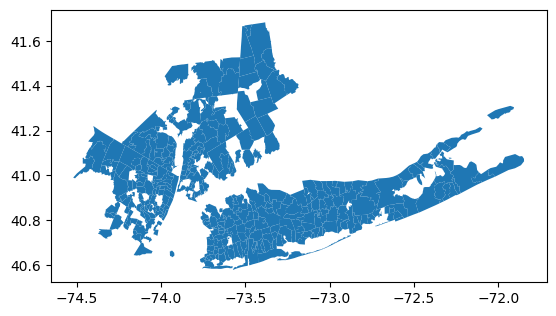

In [35]:
cols = ed_level | {"state": "state_fips", "COUNTY": "county_fips", "NAME": "county", "GEO_ID": "geoid", "zip code tabulation area": "zipcode"}
df.rename(columns=cols, inplace=True)

zip_shapes = gpd.read_file("./data/nyc-metro-zipcodes.geojson")
df = zip_shapes[["zipcode", "geometry"]].merge(df, on="zipcode")
df.plot()